In [2]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

C:\Users\Mahe\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import gc

In [4]:
train=pd.read_csv('input/train.csv')
test=pd.read_csv('input/test.csv')

In [5]:
#train.head()

In [6]:
#train.isnull().any(),test.isnull().any()

In [7]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y=train[list_classes].values
list_sentences_train=train['comment_text']
list_sentences_test=test['comment_text']

In [8]:
max_features=20000
tokenizer=Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train=tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test=tokenizer.texts_to_sequences(list_sentences_test)

In [9]:
EMBEDDING_FILE="input/glove-twitter/glove.twitter.27B.25d.txt"
embed_size=25
embeddings_index=dict()
f=open(EMBEDDING_FILE,encoding='utf-8')
for line in f:
    #values=line.split()
    #word=values[0]
    #coefs=np.asarray(values[1:],dtype='float32')
    #embeddings_index[word]=coefs
    values = line.split()
    word = ''.join(values[:-25])
    coefs = np.asarray(values[-25:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
gc.collect()
all_embs=np.stack(list(embeddings_index.values()))
emb_mean,emb_std=all_embs.mean(),all_embs.std()
nb_words=len(tokenizer.word_index)
embedding_matrix=np.random.normal(emb_mean,emb_std,(nb_words,embed_size))
gc.collect()
embeddedCount=0
for word,i in tokenizer.word_index.items():
    i-=1
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector
        embeddedCount+=1
del(embeddings_index)
gc.collect()

0

In [10]:
embedding_matrix.shape

(210337, 25)

In [11]:
#tokenizer.word_counts
#tokenizer.word_index

In [12]:
#list_tokenized_train[:1]

In [13]:
maxlen=200
X_t=pad_sequences(list_tokenized_train,maxlen=maxlen)
X_te=pad_sequences(list_tokenized_test,maxlen=maxlen)

In [14]:
#totalNumWords=[len(one_comment) for one_comment in list_tokenized_train]

In [15]:
#plt.hist(totalNumWords,bins=np.arange(0,410,10))
#plt.show()

In [16]:
inp=Input(shape=(maxlen,))

In [17]:
#embed_size=128
#x=Embedding(max_features,embed_size)(inp)

In [18]:
x=Embedding(len(tokenizer.word_index),embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)

In [19]:
#x=LSTM(60,return_sequences=True,name='lstm_layer')(x)

In [20]:
x=Bidirectional(LSTM(60,return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)

In [21]:
x=GlobalMaxPool1D()(x)

In [22]:
x=Dropout(0.1)(x)

In [23]:
x=Dense(50,activation='relu')(x)

In [24]:
x=Dropout(0.1)(x)

In [25]:
x=Dense(6,activation='sigmoid')(x)

In [26]:
model=Model(inputs=inp,outputs=x)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 25)           5258425   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 120)          41280     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 120)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

In [28]:
#batch_size=32
#epochs=2
#hist=model.fit(X_t,y,batch_size=batch_size,epochs=epochs,validation_split=0.1)

In [29]:
batch_size=32
epochs=1
hist=model.fit(X_t,y,batch_size=batch_size,epochs=epochs,validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/1
143613/143613 [==============================] - 1858s 13ms/step - loss: 0.1169 - acc: 0.9657 - val_loss: 0.0960 - val_acc: 0.9695


In [30]:
print(hist.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


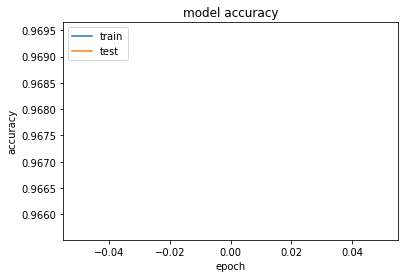

In [37]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

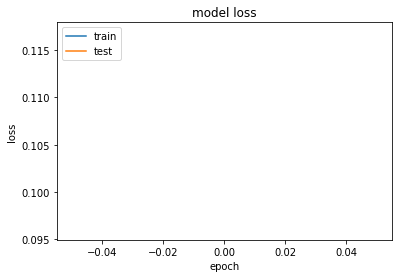

In [38]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
import pickle
pickle.dump(model,open("model.pkl","wb"))

In [35]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
model.save('my_model.h5')

In [39]:
model.save_weights('my_model_weights.h5')